 # Basic Data Science in Python - Exercises 30/9 #

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import torch
from torch import optim
import torch.nn as nn

### Exercise 1: Neural Nets in Sklearn
So far we have been using models only from Sklearn. Sklearn has some support for neural networks, however packages like Pytorch and Keras are much more flexible. Let's try out the simple [Multi-Layer Perceptron classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) from the Sklearn library.
Try different activation functions, hidden layers and solvers to see which works best. Remember what you know of overfitting!

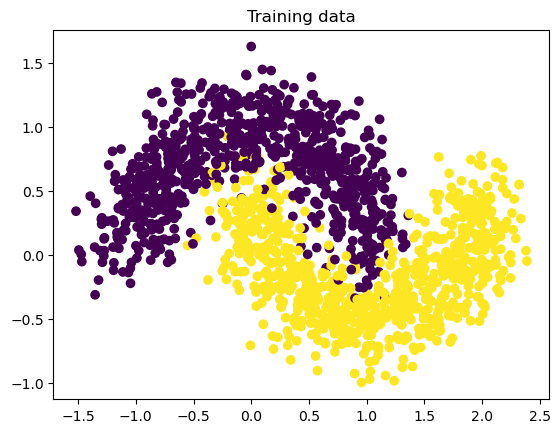

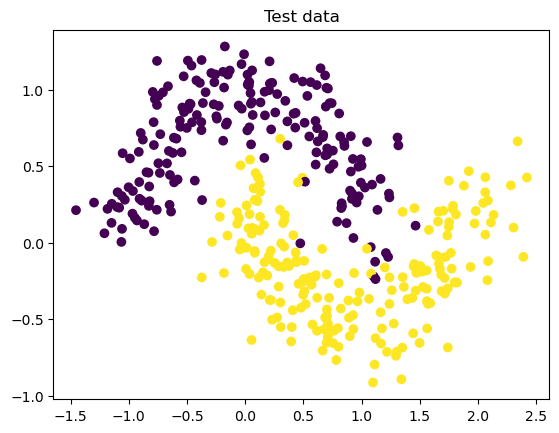

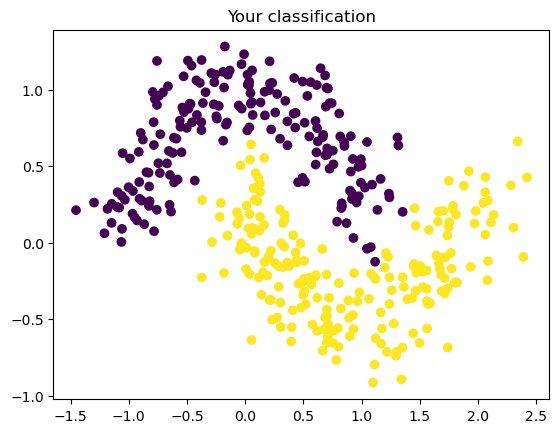

In-sample score: 0.966875
Test score: 0.965


In [2]:
X, y = datasets.make_moons(n_samples=2000, noise=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Plot the training data
plt.scatter(*X_train.T, c=y_train)
plt.title("Training data")
plt.show()
pred = None

### YOUR CODE HERE 
hidden_layers = (32,64,32)
mlp = MLPClassifier(hidden_layer_sizes= hidden_layers, 
                    max_iter=1000, 
                    activation="tanh",
                    solver="adam"
                   )
mlp.fit(X_train, y_train)
pred = mlp.predict(X_test)
### YOUR CODE HERE

plt.scatter(*X_test.T, c=y_test)
plt.title("Test data")
plt.show()
plt.scatter(*X_test.T, c=pred)
plt.title("Your classification")
plt.show()
print("In-sample score:", mlp.score(X_train, y_train))
print("Test score:", mlp.score(X_test, y_test))

### Exercise 2: Overfitting
Below we have fitted a dataset of 15 points with a polynomium. How has the overfitting occoured? Can you fix it?

Best degree: 9


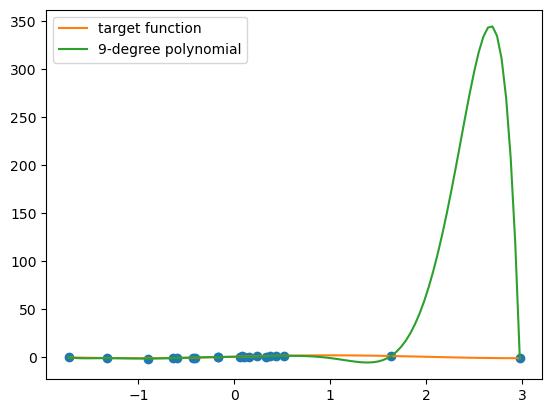

In [4]:
def target_function(x):
    return 1.5*np.sin(0.5*np.pi*x)

X = np.sort(np.random.randn(20))
y = target_function(X) + np.random.randn(20)*0.2
plt.plot(X, y, "o")

best_deg = None
best_score = 0

for deg in range(1, 10):
    polynomial_features = PolynomialFeatures(degree=deg, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression),
        ])
    pipeline.fit(X[:, np.newaxis], y)
    if pipeline.score(X[:, np.newaxis], y) > best_score:
        best_deg = deg
        best_score = pipeline.score(X[:, np.newaxis], y)
        
print("Best degree:", best_deg)

polynomial_features = PolynomialFeatures(degree=best_deg, include_bias=False)

linear_regression = LinearRegression()
pipeline = Pipeline([
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression),
        ])

x = np.linspace(X.min(), X.max(), 100)
pipeline.fit(X[:, np.newaxis], y)
plt.plot(x, target_function(x), label="target function")
plt.plot(x, pipeline.predict(x[:, np.newaxis]), label=f"{best_deg}-degree polynomial")
plt.legend()

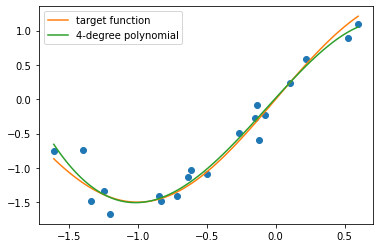

In [19]:
degree = 4
polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)

linear_regression = LinearRegression()
pipeline = Pipeline([
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression),
        ])
plt.plot(X, y, "o")
x = np.linspace(X.min(), X.max(), 100)
pipeline.fit(X[:, np.newaxis], y)
plt.plot(x, target_function(x), label="target function")
plt.plot(x, pipeline.predict(x[:, np.newaxis]), label=f"{degree}-degree polynomial")
plt.legend()

### Exercise 3: Implement a Regression Neural Net with one hidden layer
Implement a neural network with one hidden layer with Pytorch, with the [clamp](https://pytorch.org/docs/stable/generated/torch.clamp.html) function as non-linear activation function. Use Pytorch's [stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer to perform Gradient Descent.

We will be using the mean squared loss function with weight decay: $$\frac{1}{n}\sum_{i=1}^n (NN(x_i) - y_i)^2 +  c \sum_{i=1}^d W_i^2$$
See if you can combat overfitting.

In [5]:
class NN():
    
    def init(self):
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        
    def predict(self, X, W1, b1, W2, b2):
        ### YOUR CODE HERE
        input_layer = X @ W1 + b1
        output_layer = input_layer.clamp(min=0) @ W2 + b2
        ### YOUR CODE HERE
        return output_layer
    
    def fit(self, X, y, hidden_size=32, epochs=100, eps=0.01, c=0.01):
        W1 = torch.randn(X.shape[1], hidden_size, requires_grad = True)
        b1 = torch.randn(1, hidden_size, requires_grad = True)
        W2 = torch.randn(hidden_size, 1, requires_grad = True)
        b2 = torch.randn(1, 1, requires_grad = True)  
        sgd = optim.SGD(params={W1, b1, W2, b2}, lr=0.01)
        ### YOUR CODE HERE
        for epoch in range(epochs):
            sgd.zero_grad()
            loss = self.cost(X, y, W1, b1, W2, b2, c=c)
            if epoch % (epochs//10) == 0:
                print("Loss in iteration", epoch, ":", loss.item())
            loss.backward()
            sgd.step()
        ### YOUR CODE HERE
        self.W1 = W1
        self.W2 = W2
        self.b1 = b1
        self.b2 = b2
        
    #Calculate the mean squared loss
    def cost(self, X, y, W1, b1, W2, b2, c=0.0):
        loss = None
        ### YOUR CODE HERE
        pred = self.predict(X, W1, b1, W2, b2)
        loss = torch.mean((pred-y)**2) 
        loss = loss + c * (torch.sum(W1**2) + torch.sum(W2**2))
        ### YOUR CODE HERE
        return loss

    
    def score(self, X, y):
        return self.cost(X, y, self.W1, self.b1, self.W2, self.b2, c=0.0)

In [9]:
boston = datasets.fetch_california_housing()
X, y = boston.data, boston.target
#Normalize the dataset
X = (X - X.mean(axis=0))/(X.std(axis=0))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
tX_train = torch.from_numpy(X_train).float()
tX_test = torch.from_numpy(X_test).float()
ty_train = torch.from_numpy(y_train).float().view(-1, 1)
ty_test = torch.from_numpy(y_test).float().view(-1, 1)

#Loss go down means model more gooder!
net = NN()
net.fit(tX_train, ty_train, epochs=100, hidden_size=16)
print("Test score: ", net.score(tX_test, ty_test).item())

Loss in iteration 0 : 45.24418258666992
Loss in iteration 9 : 5.798559188842773
Loss in iteration 18 : 3.99318265914917
Loss in iteration 27 : 3.4285824298858643
Loss in iteration 36 : 3.116316318511963
Loss in iteration 45 : 2.905818462371826
Loss in iteration 54 : 2.7518491744995117
Loss in iteration 63 : 2.6324524879455566
Loss in iteration 72 : 2.5361924171447754
Loss in iteration 81 : 2.4566125869750977
Test score:  1.1788023710250854


### Exercise 4: Implement Perceptron (Hard)
Implement a simple perceptron learning algorithm for linearly seperable data. Test your implementation on the below dataset

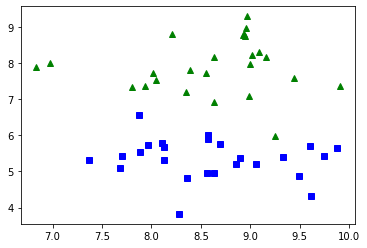

In [22]:
X, Y = datasets.make_blobs(n_samples=50, centers=2, n_features=2, center_box=(0, 10), cluster_std=0.7)
Y = 2*Y-1
plt.plot(X[:, 0][Y == -1], X[:, 1][Y == -1], 'g^')
plt.plot(X[:, 0][Y == 1], X[:, 1][Y == 1], 'bs')
plt.show()

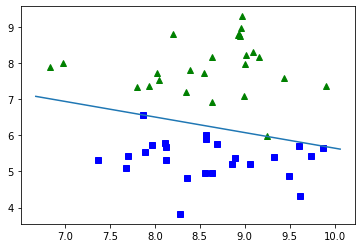

In [23]:
class Perceptron():
    
    def __init__(self):
        self.w = None
        self.b = None
    
    def fit(self, X, Y):
        w = np.array([0, 0])
        b = 0
        ### YOUR CODE HERE
        while True:
            hyper_plane = np.sign(np.dot(w, X.T)+b)
            bad = np.where(hyper_plane != Y)[0]
            if len(bad) == 0:
                break
            idx = np.random.choice(bad)
            x = X[idx]
            y = Y[idx]
            w = w + y*x
            b += y
        ### YOUR CODE HERE
        self.w = w
        self.b = b
    
    def predict(self, X):
        prediction = None
        ### YOUR CODE HERE
        prediction = np.sign(np.dot(w))
        ### YOUR CODE HERE
        return prediction
        

#For plotting your hyperplane!
clf = Perceptron()
clf.fit(X, Y)
w, b = clf.w, clf.b
fig, ax = plt.subplots()
ax.plot(X[:, 0][Y == -1], X[:, 1][Y == -1], 'g^')
ax.plot(X[:, 0][Y == 1], X[:, 1][Y == 1], 'bs')
xmin, xmax, _, _ = ax.axis()
x = np.array([xmin, xmax])
y = (-b - w[0]*x)/w[1]
plt.plot(x, y)
plt.show()